<a href="https://colab.research.google.com/github/harvarsri/TCS-iON/blob/master/EAST_Text_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing The Libraries

from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
from google.colab.patches import cv2_imshow

In [0]:
#Loading the Input Image & Dimensions of Image

image = cv2.imread('/content/drive/My Drive/east/images/lebron_james.jpg') #Location of the IMG File
orig = image.copy()
(H, W) = image.shape[:2]

In [0]:
# set the new width and height and then determine the ratio in change
# for both the width and height

(newW, newH) = (640, 320)
rW = W / float(newW)
rH = H / float(newH)

In [0]:
# Resizing & Grabbing Dimensions of Image

image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [0]:
#Layer1=Probabilistic Layer2=Coordinates for Drawn Boxes

layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

In [0]:
#Loading Pretrained East Detector

net = cv2.dnn.readNet('/content/drive/My Drive/east/frozen_east.pb') #Location Of frozen_east.db file

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets

blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

In [0]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

In [0]:
# loop over the number of rows

for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5 :
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])


In [0]:
#apply non-maxima suppression to suppress weak, overlapping bounding  boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

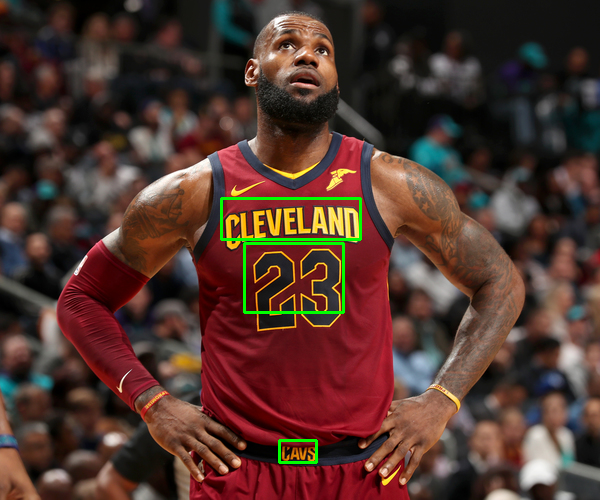

-1

In [10]:
# show the output image

cv2_imshow(orig)
cv2.waitKey(0)